# Getting started with preprocessed IXPE data

## Learning Goals

By the end of this tutorial, you will be able to:

- Find and access preprocessed ("level 2") IXPE data.
- Extract events from source and background regions.
- Perform an initial spectro-polarimetric fit to the IXPE data.

## Introduction

This notebook is intended to get you started using and analyzing observations taken by the
Imaging X-ray Polarimetry Explorer (IXPE); a NASA X-ray telescope that can measure the polarization of
incident X-ray photons, in addition to their position, arrival time, and energy.

IXPE's primary purpose is to study the polarization of emission from a variety of X-ray sources, and it is the first
NASA X-ray telescope dedicated to polarization studies. These capabilities mean that IXPE data are, in some respects,
unlike those of other X-ray telescopes (Chandra, XMM, eROSITA, etc.), and special care needs to be taken when
analyzing them.

```{hint}
We highly recommend that new users read both the IXPE quick start guide and the recommendations
for statistical treatment of IXPE data documentments - links can be found in the 'additional resources' section of
this notebook.
```

We do not require the reprocessing of data for this example, the preprocessed ("level 2") data products are sufficient.

If you need to reprocess the data, IXPE tools are available in the ```heasoftpy``` Python package.

### Inputs

- The IXPE ObsID, 01004701, of the data we will process (an observation of a blazar, **Mrk 501**).

### Outputs

- Newly generated IXPE spectra-polarimetric data products and supporting files.
- Visualizations of count-rate spectra.
- Visualizations of polarization spectra.

### Runtime

As of 15th January 2026, this notebook takes ~90s to run to completion on Fornax using the 'Default Astrophysics' image and the 'small' server with 8GB RAM/ 2 cores.


## Imports

In [1]:
import contextlib
import glob
import itertools
import multiprocessing as mp
import os

import heasoftpy as hsp
import matplotlib.pyplot as plt
import numpy as np
import xspec as xs
from astroquery.heasarc import Heasarc
from matplotlib.ticker import FuncFormatter

## Global Setup

### Functions

In [2]:
def extract_spec(inst: str, region_file: str):
    """
    A function that will use HEASoftPy to extract a source or background spectrum
    from an IXPE Level 2 event file.

    :param inst: The instrument name (e.g. 'det1', 'det2', 'det3')
    :param region_file: The region file to use for extraction.
    """

    spec_out = os.path.join(
        OUT_PATH,
        "ixpe_{i}_{r}_.pha".format(i=inst.lower(), r=region_file.split(".")[0]),
    )
    region_file = os.path.join(OUT_PATH, region_file)

    # Setting 'allow_failure=False' means exceptions will be raised if the call fails
    with hsp.utils.local_pfiles_context():
        out = hsp.extractor(
            filename=evt_file_paths[inst.lower()],
            binlc=10.0,
            eventsout="NONE",
            imgfile="NONE",
            fitsbinlc="NONE",
            phafile=spec_out,
            regionfile=region_file,
            timefile="NONE",
            stokes="NEFF",
            polwcol="W_MOM",
            tcol="TIME",
            ecol="PI",
            xcolf="X",
            xcolh="X",
            ycolf="Y",
            ycolh="Y",
            noprompt=True,
            clobber=True,
            allow_failure=False,
        )

    return out

### Constants

In [3]:
# IXPE ObsID that we will use for this example.
OBS_ID = "01004701"
SRC_NAME = "Mrk 501"

# The name of the HEASARC table that logs all IXPE observations
HEASARC_TABLE_NAME = "ixmaster"

### Configuration

In [4]:
# ------------- Configure global package settings --------------
# Raise Python exceptions if a heasoftpy task fails
# TODO Remove once this becomes a default in heasoftpy
hsp.Config.allow_failure = False

# Set up the method for spawning processes.
mp.set_start_method("fork", force=True)
# --------------------------------------------------------------


# ------------- Setting how many cores we can use --------------
NUM_CORES = None
total_cores = os.cpu_count()

if NUM_CORES is None:
    NUM_CORES = total_cores
elif not isinstance(NUM_CORES, int):
    raise TypeError(
        "If manually overriding 'NUM_CORES', you must set it to an integer value."
    )
elif isinstance(NUM_CORES, int) and NUM_CORES > total_cores:
    raise ValueError(
        f"If manually overriding 'NUM_CORES', the value must be less than or "
        f"equal to the total available cores ({total_cores})."
    )
# --------------------------------------------------------------


# -------------- Set paths and create directories --------------
# Set up the path of the directory into which we will download IXPE data
if os.path.exists("../../../_data"):
    ROOT_DATA_DIR = os.path.join(os.path.abspath("../../../_data"), "IXPE", "")
else:
    ROOT_DATA_DIR = "IXPE/"

# Whatever the data directory is, make sure it is absolute.
ROOT_DATA_DIR = os.path.abspath(ROOT_DATA_DIR)

# Make sure the download directory exists.
os.makedirs(ROOT_DATA_DIR, exist_ok=True)

# Setup path and directory into which we save output files from this example.
OUT_PATH = os.path.abspath("IXPE_output")
os.makedirs(OUT_PATH, exist_ok=True)
# --------------------------------------------------------------

***

## 1. Downloading the IXPE data files for 01004701

We've already decided on the IXPE observation we're going to use for this example - as such we don't need an
explorative stage where we use the name of our target, and its coordinates, to find an appropriate observation.

What we do need to know is where the data are stored, and to retrieve a link that we can use to download them - we
can achieve this using the IXPE summary table of observations, accessed using `astroquery`.

The name of the observation table is stored in the `HEASARC_TABLE_NAME` constant, set up in the collapsed 'Global Setup: Constants' subsection above:

In [5]:
HEASARC_TABLE_NAME

'ixmaster'

First, we construct a simple astronomical data query language (ADQL) query to find the row of the observation summary table
that corresponds to our chosen ObsID. This retrieves every column of the row whose ObsID matches the one we're looking for:

In [6]:
query = (
    "SELECT * "
    "from {c} as cat "
    "where cat.obsid='{oi}'".format(oi=OBS_ID, c=HEASARC_TABLE_NAME)
)

query

"SELECT * from ixmaster as cat where cat.obsid='01004701'"

The query is then executed, and the returned value is converted to an Astropy table (necessary for the next step):

In [7]:
obs_line = Heasarc.query_tap(query).to_table()
obs_line

__row,obsid,name,ra,dec,lii,bii,roll_angle_req,time,end_time,fcw_1,fcw_2,fcw_3,exposure_1,exposure_2,exposure_3,ontime_1,ontime_2,ontime_3,processing_date,public_date,software_version,obs_type,coordinated,issue_flag,status,caldb_version,comments,prnb,title,pi_names,abstract,subject_category,category_code,priority,cycle,__x_ra_dec,__y_ra_dec,__z_ra_dec
,,,deg,deg,deg,deg,deg,d,d,,,,s,s,s,s,s,s,d,d,,,,,,,,,,,,,,,,,,
object,object,object,float64,float64,float64,float64,float64,float64,float64,object,object,object,float64,float64,float64,float64,float64,float64,float64,float64,object,object,object,int16,object,object,object,int32,object,object,object,object,int16,object,int16,float64,float64,float64
285,01004701,MRK 501,253.4676,39.7602,63.6001,38.8591,--,59769.97458428,59772.04337753,open,open,open,97794.9257,96095.4274,97827.2522,97916.2185,96245.1984,97940.3379,59780.72141469,59788,Hea_10Mar2022_V6.30_IXPE_21JUNE2022_1.5,proposed,,0,archived,,,--,,IXPE Team,,Bla,7,3,1,-0.736947981589561,-0.218747312767553,0.639575863825431


From there we can easily identify the 'data link' that we need to download the actual data files - we simply pass the query return
to the `locate_data` method of `Heasarc`:

In [8]:
data_links = Heasarc.locate_data(obs_line, HEASARC_TABLE_NAME)
data_links

ID,access_url,sciserver,aws,content_length,error_message
,,,,byte,
object,object,str31,str44,int64,object
ivo://nasa.heasarc/ixmaster?285,https://heasarc.gsfc.nasa.gov/FTP/ixpe/data/obs/01//01004701/,/FTP/ixpe/data/obs/01/01004701/,s3://nasa-heasarc/ixpe/data/obs/01/01004701/,1203321946,


This data link can be passed straight into the `download_data` method of `Heasarc`, and our observation data files
will be downloaded into the directory specified by `ROOT_DATA_DIR`.

In [9]:
Heasarc.download_data(data_links, host="aws", location=ROOT_DATA_DIR)

INFO: Downloading data AWS S3 ... [astroquery.heasarc.core]
INFO: Enabling anonymous cloud data access ... [astroquery.heasarc.core]
INFO: downloading s3://nasa-heasarc/ixpe/data/obs/01/01004701/ [astroquery.heasarc.core]


INFO: downloading s3://nasa-heasarc/ixpe/data/obs/01/01004701/ [astroquery.heasarc.core]


Finally, we'll take a quick look at the contents and structure of the downloaded data.

It should contain the standard IXPE data files, which include:
- `event_l1` - This directory houses 'level 1' event files, which contain raw, unprocessed, event data.
- `event_l2` - The 'level 2' event files (processed and ready for use) are stored here.
- `auxil` - Contains auxiliary data files, such as exposure maps.
- `hk` - Contains house-keeping data such as orbit files etc.

```{important}
There may also be a `README` file in the root directory of the downloaded data - if this is the case, you should
read it carefully, as it will contain information about any known issues with the processing of the data.
```

In [10]:
OBS_ID_PATH = os.path.join(ROOT_DATA_DIR, OBS_ID)
glob.glob(f"{OBS_ID_PATH}/*")

['/home/jovyan/project/_data/IXPE/01004701/auxil',
 '/home/jovyan/project/_data/IXPE/01004701/event_l1',
 '/home/jovyan/project/_data/IXPE/01004701/event_l2',
 '/home/jovyan/project/_data/IXPE/01004701/hk']

```{hint}
For a complete description of data formats of IXPE data directories, see the support documentation on the [IXPE Website](https://heasarc.gsfc.nasa.gov/docs/ixpe/analysis/#supportdoc).
```


## 2. Exploring the structure of IXPE data

The 'event_l2' directory contains three event files, one per IXPE detector. We're going to put
the full paths to these files in a directory, with the keys being 'det1', 'det2', and 'det3'; this will save us
some inelegant string formatting every time we want to access them:

In [11]:
l2_path = os.path.join(ROOT_DATA_DIR, OBS_ID, "event_l2")
l2_path_files = os.listdir(l2_path)

evt_file_paths = {
    "det{}".format(f.split("det")[-1][0]): os.path.join(l2_path, f)
    for f in l2_path_files
}

evt_file_paths

{'det1': '/home/jovyan/project/_data/IXPE/01004701/event_l2/ixpe01004701_det1_evt2_v01.fits.gz',
 'det2': '/home/jovyan/project/_data/IXPE/01004701/event_l2/ixpe01004701_det2_evt2_v01.fits.gz',
 'det3': '/home/jovyan/project/_data/IXPE/01004701/event_l2/ixpe01004701_det3_evt2_v01.fits.gz'}

Now, we'll quickly examine the structure of the event files using a HEASoft tool called `fstruct` - rather than
going to the command line, we will simply use a HEASoftPy interface:

In [12]:
out = hsp.fstruct(infile=evt_file_paths["det1"], allow_failure=False).stdout
print(out)

  No. Type     EXTNAME      BITPIX Dimensions(columns)      PCOUNT  GCOUNT
 
   0  PRIMARY                  8     0                           0    1
   1  BINTABLE EVENTS          8     48(10) 101073               0    1
 
      Column Name                Format     Dims       Units     TLMIN  TLMAX
      1 TRG_ID                     J
      2 TIME                       D                   s
      3 STATUS                     16X
      4 STATUS2                    16X
      5 PI                         J                   chan          0      374
      6 W_MOM                      E
      7 X                          E                   pixel         1      600
      8 Y                          E                   pixel         1      600
      9 Q                          D
     10 U                          D
 
   2  BINTABLE GTI             8     16(2) 95                    0    1
 
      Column Name                Format     Dims       Units     TLMIN  TLMAX
      1 START         

## 3. Extracting spectro-polarimetric data products

Here we get to the fun part - the creation and analysis of some IXPE data products!

### Defining source and background regions

To obtain source and background spectra from the 'level 2' files, we need to define source and background regions for
the extraction.

Defining regions can be done in a number of ways, using automated source finding tools, drawing them onto
images using [SAOImage DS9](https://sites.google.com/cfa.harvard.edu/saoimageds9), or (as we show here) by manually constructing region files.

In this case we define the source region as a $60^{\prime\prime}$ circle centered on Mrk 501.

The background region is an annulus with an inner radius of $132^{\prime\prime}$ and outer radius $252^{\prime\prime}$.

The region files should be independently defined for each telescope; in this example, the source location has the same celestial coordinates within 0.25" for all three detectors, so a single source and a single background region can be used.

In [13]:
with open(os.path.join(OUT_PATH, "src.reg"), "w") as srco:
    srco.write('circle(16:53:51.766,+39:45:44.41,60.000")')

with open(os.path.join(OUT_PATH, "bck.reg"), "w") as bcko:
    bcko.write('annulus(16:53:51.766,+39:45:44.41,132.000",252.000")')

### Running the extractor tool

Spectro-polarimetric data products will be extracted using another HEASoft tool called `extractor`. Again, we will
use the HEASoftPy interface rather than running directly in the command line.

Our goal is to extract I, Q, and U spectra (within the source and background regions defined above) from
IXPE 'level 2' event lists, for every detector. That means there will be three source spectra, and three
background spectra, per detector.

Help information for all HEASoftPy tools can be displayed using the `help()` function:

In [14]:
help(hsp.extractor)

Help on function extractor in module heasoftpy.fcn:

extractor(args=None, **kwargs)
    Parameters
    ----------
    exitnow            :  Exit now: (default: no)
    filename     (Req) :  Input file name: (default: good.evt)
    eventsout    (Req) :  Name of output events file: (default: NONE)
    imgfile      (Req) :  Image output file name: (default: none)
    binf               :  Rebinning factor for region selection: (default: 1)
    fullimage          :  Output image is full-size? (default: yes)
    phafile      (Req) :  PHA output FITS file name: (default: test.pha)
    specbin            :  Binning factor for spectrum: (default: 1)
    wtmapb             :  Build a WMAP for the spectrum? (default: yes)
    wtmapfix           :  Set WMAP pixels outside selected region to -1? (default: yes)
    swmapx             :  Invert X axis when converting WMAP to IMAGE coordinates (default: no)
    swmapy             :  Invert Y axis when converting WMAP to IMAGE coordinates (default: no

To maximize efficiency, and take advantage of the multiple cores we have available, we set up a parallel processing
pool using the `multiprocessing` module. The call to `extractor` is wrapped in a function that takes the detector
number and the region file to generate the product within as arguments; the function is defined in the
'Global Setup: Functions' subsection near the top of the notebook.

Output files are saved in the `OUT_PATH` directory, which is set up in the 'Global Setup: Constants' subsection.

In [15]:
arg_combs = itertools.product(list(evt_file_paths.keys()), ["src.reg", "bck.reg"])

with mp.Pool(NUM_CORES) as p:
    result = p.starmap(extract_spec, arg_combs)

Listing the files in the output directory is a good way to check that the extraction was successful, though the
HEASoftPy call will also raise exceptions if the extraction fails (as we passed `allow_failure=False`).

In [16]:
os.listdir(OUT_PATH)

['src.reg',
 'bck.reg',
 'ixpe_det1_bck_I.pha',
 'ixpe_det3_bck_I.pha',
 'ixpe_det2_bck_I.pha',
 'ixpe_det3_src_I.pha',
 'ixpe_det1_src_I.pha',
 'ixpe_det2_src_I.pha',
 'ixpe_det1_bck_Q.pha',
 'ixpe_det3_bck_Q.pha',
 'ixpe_det2_bck_Q.pha',
 'ixpe_det3_src_Q.pha',
 'ixpe_det3_bck_U.pha',
 'ixpe_det1_bck_U.pha',
 'ixpe_det2_bck_U.pha',
 'ixpe_det1_src_Q.pha',
 'ixpe_det3_src_U.pha',
 'ixpe_det2_src_Q.pha',
 'ixpe_det1_src_U.pha',
 'ixpe_det2_src_U.pha']

### Obtaining response files

Performing any meaningful analysis of IXPE spectro-polarimetric data requires response files that describe the
sensitivity and characteristics of the instruments. These include the standard 'Response Matrix File' (RMF) and
'Ancillary Response File' (ARF) files, which map the detector channels to specific energies and describe how the
sensitivity of the detector changes with energy respectively; it also includes the non-standard 'Modulation Response File' (MRF)
files.

```{note}
The MRF is defined by the product of the energy-dependent modulation factor, $\mu$(E) and the ARF. The modulation
factor is what map the 'photo-electron tracks' measured by IXPE's detectors to the physical polarization degree.
```

For a given IXPE detector, the 'I' spectrum requires different response files to the 'Q' and 'U' spectra.

- **I** - The RMF and ARF describe the response.
- **Q** and **U** - The RMF and *MRF* describe the response.

We're going to fetch these files from the HEASARC CalDB, or rather we'll fetch links to them, as we can use a remote
IXPE CalDB for our spectral analysis later. The HEASoft tool `quzcif` allows us to search the remote CalDB - we can
find out more about this tool examining the help information:

In [17]:
help(hsp.quzcif)

Help on function quzcif in module heasoftpy.fcn:

quzcif(args=None, **kwargs)
    Parameters
    ----------
    mission      (Req) :  Name of Mission (default: )
    instrument   (Req) :  Name of Instrument (default: )
    detector     (Req) :  Name of Detector (- if not required) (default: -)
    filter       (Req) :  Name of Filter (- if not required) (default: -)
    codename     (Req) :  Calibration Dataset Codename (default: )
    date         (Req) :  Requested Date in yyyy-mm-dd format (default: )
    time         (Req) :  Requested Time in hh:mm:ss format (default: )
    expr         (Req) :  Boolean selection expression for Boundary params(- if not required) (default: -)
    maxret             :  Maximum number of datasets to print to the screen (<0: return all available rows) (default: -1)
    retrieve           :  Download remote file via ftp or http? (default: no)
    clobber            :  Overwrite existing output file? (default: no)
    chatter            :  Chatter flag 

Note that the output of `hsp.quzcif` for a particular detector/file-type combination provides links to multiple files.

This is because there are three sets of response files, corresponding to the different weighting schemes, as well as
different versions of those files.

- For the 'NEFF' weighting, use 'alpha07_`vv`'.
- For the 'SIMPLE' weighting, use 'alpha075simple_`vv`'.
- For the 'UNWEIGHTED' version, use '20170101_`vv`'.

Where `vv` is the version number of the response files.

```{important}
We strongly recommend that you use the latest version of the response files!
```

For our example, we're going to use `vv = 02` for the RMF and `vv = 03` for the ARF and MRF.

#### Setting response versions

We'll set up variables to hold the response version numbers:

In [18]:
rmf_ver = "02"
arf_ver = "03"
mrf_ver = "03"

#### Using `quzcif` to get the response files

Now we use the HEASARC tool to actually fetch the response files:

In [19]:
# Getting the on-axis RMFs, ARFs, and MRFs

resps = {det: {"rmf": None, "arf": None, "mrf": None} for det in evt_file_paths.keys()}

for det in evt_file_paths.keys():
    det_str = "DU{}".format(det[-1])

    rmf_res = hsp.quzcif(
        mission="ixpe",
        instrument="gpd",
        detector=det_str,
        filter="-",
        date="-",
        time="-",
        expr="-",
        codename="MATRIX",
        allow_failure=False,
    )
    resps[det]["rmf"] = [
        x.split()[0] for x in rmf_res.output if "alpha075_{}".format(rmf_ver) in x
    ][0]

    arf_res = hsp.quzcif(
        mission="ixpe",
        instrument="gpd",
        detector=det_str,
        filter="-",
        date="-",
        time="-",
        expr="-",
        codename="SPECRESP",
        allow_failure=False,
    )
    resps[det]["arf"] = [
        x.split()[0] for x in arf_res.output if "alpha075_{}".format(arf_ver) in x
    ][0]

    mrf_res = hsp.quzcif(
        mission="ixpe",
        instrument="gpd",
        detector=det_str,
        filter="-",
        date="-",
        time="-",
        expr="-",
        codename="MODSPECRESP",
        allow_failure=False,
    )

    resps[det]["mrf"] = [
        x.split()[0] for x in mrf_res.output if "alpha075_{}".format(mrf_ver) in x
    ][0]

## 4. Loading spectro-polarimetric data into pyXspec and fitting a model

We now have everything we need to load the extracted spectra into pyXspec and fit a model to them!

### Configuring PyXspec

Here we configure some of pyXspec's behaviors. We set the verbosity to '0' to suppress printed output, make sure the
plot axes are energy (for the x-axis), and normalized counts per second (for the y-axis).

In [20]:
# Severely imits the output of pyXspec, though chatter = 0 will still
#  let some messages through.
xs.Xset.chatter = 0

# Other xspec settings
xs.Plot.area = True
xs.Plot.xAxis = "keV"
xs.Plot.background = True
xs.Fit.query = "no"
xs.Fit.nIterations = 500

### Reading the spectra into pyXspec

This snippet uses our previously defined `resps` dictionary to load the spectra and their requisite response files
into pyXspec. The 'I', 'U', and 'Q' spectra are all loaded in for each detector. The 'contextlib.chdir' statement is
used to change the working directory to the directory containing spectral files so that the spectra can be loaded, and
then to ensure that the working directory is reset.

In [21]:
xs.AllData.clear()

resps = {det: resps[det] for det in sorted(resps)}

with contextlib.chdir(OUT_PATH):

    x = 0  # Iterator index to keep the spectrum numbering correct
    for det, supp_files in resps.items():
        du = int(det[-1])

        # ----------- Load the I data -----------
        xs.AllData("%i:%i ixpe_det%i_src_I.pha" % (du, du + x, du))
        xs.AllData(f"{du}:{du+x} ixpe_det{du}_src_I.pha")
        s = xs.AllData(du + x)

        # Load response and background files
        s.response = supp_files["rmf"]
        s.response.arf = supp_files["arf"]
        s.background = "ixpe_det%i_bck_I.pha" % du
        # ---------------------------------------

        # ----------- Load the Q data -----------
        xs.AllData("%i:%i ixpe_det%i_src_Q.pha" % (du, du + x + 1, du))
        s = xs.AllData(du + x + 1)

        # #Load response and background files
        s.response = supp_files["rmf"]
        s.response.arf = supp_files["mrf"]
        s.background = "ixpe_det%i_bck_Q.pha" % du
        # ---------------------------------------

        # ----------- Load the U data -----------
        xs.AllData("%i:%i ixpe_det%i_src_U.pha" % (du, du + x + 2, du))
        s = xs.AllData(du + x + 2)

        # #Load response and background files
        s.response = supp_files["rmf"]
        s.response.arf = supp_files["mrf"]
        s.background = "ixpe_det%i_bck_U.pha" % du
        # ---------------------------------------

        x += 2

### Selecting the energy range to fit
We decide to ignore all channels that are outside the 2.0-8.0 keV energy range, as this is the nominal 'usable'
energy range for IXPE.

```{danger}
Do not pass integers to `ignore` when trying to ignore an energy range, as that will actually
ignore a range of **channels**. So don't be tempted to use xs.AllData.ignore("0-2, 8-**") here!
```

In [22]:
xs.AllData.ignore("0.0-2.0, 8.0-**")

### Setting up the spectro-polarimetric model

We'll to fit a fairly standard galactic-hydrogen-column-absorbed (*tbabs*) power-law model to the data (with a
multiplicative constant that accounts for the differing responses of the detectors), but we also include a more
unusual, polarization-related, model - 'polconst'.

This will constrain the polarization angle and fraction of the source, by using exploiting the 'U' and 'Q' spectra
we generated and loaded earlier. By using 'polconst' we are intrinsically assuming that the polarization angle is
constant with energy.

In [23]:
# Set up the model that we want to fit
model = xs.Model("polconst*tbabs(constant*powerlaw)")

# Set initial guesses for parameter values
model.polconst.A = 0.05
model.polconst.psi = -50
model.TBabs.nH = 0.15
model.powerlaw.PhoIndex = 2.7
model.powerlaw.norm = 0.1

The previous step sets up a different version of our model for each detector but also links many of the parameters.
This means that we are jointly fitting the data for each instrument, which increases our constraining power over fitting
an individual instrument.

Here we read out the separate models and set the constant multiplicative factor for each instrument.

In [24]:
m1 = xs.AllModels(1)
m2 = xs.AllModels(2)
m3 = xs.AllModels(3)

m1.constant.factor = 1.0
m1.constant.factor.frozen = True
m2.constant.factor = 0.8
m3.constant.factor = 0.9

### Running the model fit through pyXspec

In [25]:
xs.Fit.perform()

We can use the `show` method to examine the final parameter values of the fitted model (we have to temporarily relax the zero verbosity we set earlier on):

In [26]:
xs.Xset.chatter = 5
xs.AllModels.show()
xs.Xset.chatter = 0

## 5. Visualizing the results

We will now extract information from pyXspec and plot various aspects of the fitted models and results using the
`matplotlib` package. This offers more flexibility than the built-in plotting functions in pyXspec.

### A 'traditional' X-ray spectrum

We can fetch the count rate, and energy bin centers, from pyXspec:

In [27]:
# This command will construct a logged-data plot of the spectrum
xs.Plot("lda")

yVals = xs.Plot.y()
yErr = xs.Plot.yErr()
xVals = xs.Plot.x()
xErr = xs.Plot.xErr()
mop = xs.Plot.model()

Using that information, we can plot a 'traditional' X-ray spectrum:

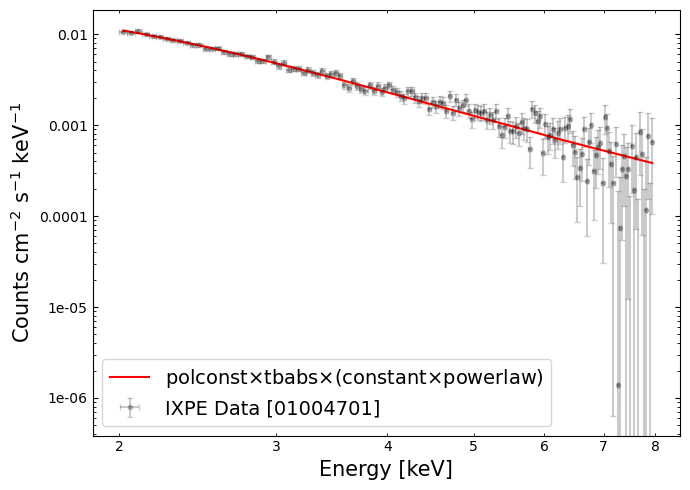

In [28]:
fig = plt.figure(figsize=(7, 5))
plt.minorticks_on()
plt.tick_params(which="both", direction="in", top=True, right=True)

# Plot the spectral data points, with error bars
plt.errorbar(
    xVals,
    yVals,
    xerr=xErr,
    yerr=yErr,
    fmt="k.",
    alpha=0.2,
    capsize=2,
    label="IXPE Data [01004701]",
)

# Add the fitted model line to the plot
plt.plot(
    xVals, mop, "r-", label=r"polconst$\times$tbabs$\times$(constant$\times$powerlaw)"
)

plt.xscale("log")
plt.yscale("log")

plt.gca().xaxis.set_minor_formatter(FuncFormatter(lambda inp, _: "{:g}".format(inp)))
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda inp, _: "{:g}".format(inp)))

plt.xlabel("Energy [keV]", fontsize=15)
plt.ylabel(r"Counts cm$^{-2}$ s$^{-1}$ keV$^{-1}$", fontsize=15)

plt.legend(loc="best", fontsize=14)
plt.tight_layout()
plt.show()

### Polarization angle vs. energy

This part of the data and model is constraining the polarization angle, which by our model choice (particularly the
'polconst' component) is assumed to be constant with energy.

We can extract the data and model information that will let us plot the polarization angle against energy:

In [29]:
xs.Plot("polangle")
yVals = xs.Plot.y()
yErr = [abs(y) for y in xs.Plot.yErr()]
xVals = xs.Plot.x()
xErr = xs.Plot.xErr()
mop = xs.Plot.model()

This visualization will help us understand how good the assumption of constant polarization with energy appears to be:

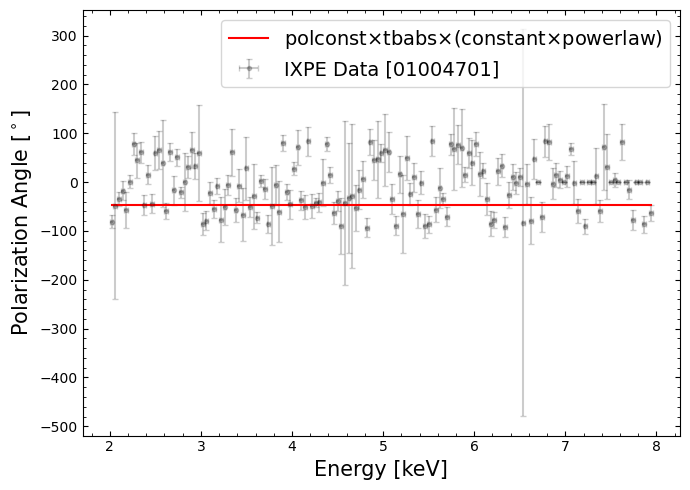

In [30]:
fig = plt.figure(figsize=(7, 5))
plt.minorticks_on()
plt.tick_params(which="both", direction="in", top=True, right=True)

plt.errorbar(
    xVals,
    yVals,
    xerr=xErr,
    yerr=yErr,
    fmt="k.",
    alpha=0.2,
    capsize=2,
    label="IXPE Data [01004701]",
)
plt.plot(
    xVals, mop, "r-", label=r"polconst$\times$tbabs$\times$(constant$\times$powerlaw)"
)

plt.xlabel("Energy [keV]", fontsize=15)
plt.ylabel(r"Polarization Angle [$^\circ$]", fontsize=15)

plt.legend(loc="best", fontsize=14)
plt.tight_layout()
plt.show()

## 6. Interpreting the results from XSPEC

There are two parameters of interest in our example; the polarization **fraction** (A),
and the polarization **angle** ($\psi$). The XSPEC error (or uncertainty) command can be used
to deduce confidence intervals for these parameters.

We can estimate the 99% confidence interval for these two parameters.

In [31]:
# Parameter 1 is the polarization fraction
xs.Fit.error("6.635 1")

# Parameter 2 is the polarization angle
xs.Fit.error("6.635 2")  # Uncertainty on parameter 2

Of particular interest is the 2D error contour for the polarization fraction and polarization angle - we use XSPEC's
`steppar` command to 'walk' around the polarization fraction and angle parameter spaces.

In [32]:
lch = xs.Xset.logChatter
xs.Xset.logChatter = 20

# Create and open a log file for XSPEC output.
# This step can sometimes take a few minutes. Please be patient!
logFile = xs.Xset.openLog(os.path.join(OUT_PATH, "steppar.txt"))

xs.Fit.steppar("1 0.00 0.21 41 2 -90 0 36")

# Close XSPEC's currently opened log file.
xs.Xset.closeLog()

With the error estimation complete, we'll extract the plotting information from pyXspec:

In [33]:
# Fetch the plotting information
xs.Plot("contour ,,4 1.386, 4.61 9.21 13.81")
yVals = xs.Plot.y()
xVals = xs.Plot.x()
zVals = xs.Plot.z()

levelvals = xs.Plot.contourLevels()
statval = xs.Fit.statistic

Then plot the error contour for our two polarization parameters.

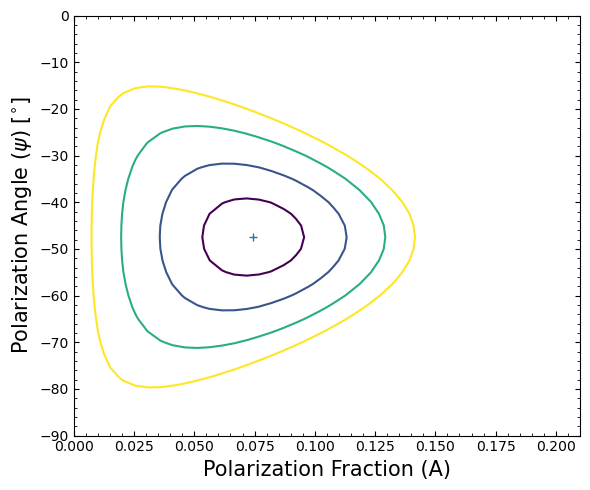

In [34]:
fig = plt.figure(figsize=(6, 5))
plt.minorticks_on()
plt.tick_params(which="both", direction="in", top=True, right=True)

plt.contour(xVals, yVals, zVals, levelvals)
plt.errorbar(m1.polconst.A.values[0], m1.polconst.psi.values[0], fmt="+")

plt.ylabel(r"Polarization Angle ($\psi$) [$^{\circ}$]", fontsize=15)
plt.xlabel("Polarization Fraction (A)", fontsize=15)

plt.tight_layout()
plt.show()

### Determining the flux and calculating MDP

Note that the detection is deemed "highly probable" (confidence C > 99.9%) as A/$\sigma$ = 4.123 >$\sqrt{-2 ln(1- C)}$, where $\sigma$ = 0.01807 as given by XSPEC above.

Finally, we can use PIMMS to estimate the Minimum Detectable Polarization (MDP).

To do this, we first use XSPEC to determine the (model) flux on the 2-8 keV energy range:

In [35]:
xs.AllModels.calcFlux("2.0 8.0")

Extract the calculated fluxes for stokes-I spectra (we know the indices because I spectra were loaded before Q and U spectra, and each detector was loaded in sequence - note that XSPEC indexing starts at 1, unlike Python):

In [36]:
flux_ispec = []
for sp_ind in [1, 4, 7]:
    flux_ispec.append(xs.AllData(sp_ind).flux[0])

flux_ispec

[7.942901256897255e-11, 7.589054935135048e-11, 7.084215422150606e-11]

Now we can easily calculate a mean flux:

In [37]:
np.mean(flux_ispec)

np.float64(7.538723871394304e-11)

We set up a powerlaw model in [PIMMS](https://heasarc.gsfc.nasa.gov/cgi-bin/Tools/w3pimms/w3pimms.pl), passing parameters that match the model we just fit and the flux we just calculated:
- Galactic hydrogen column density ($n_{H}$) $=0.646\times 10^{22}\:\rm{cm}^{-2}$
- Photon index ($\Gamma$) $= 2.75$
- Average flux from the three detectors ($f_{\rm{X}}$) $=7.54\times 10^{-11}$ erg cm$^{-2}$ s$^{-1}$

When simulating IXPE, we find that PIMMS returns a 'MDP99' of 5.62% for a 100 ks exposure.

Scaling by the actual mean of this observation's exposure time (97.243 ks) gives us an MDP99 of 5.70% meaning that, for an unpolarized source with these physical parameters, an IXPE observation will return a value A > 0.057 only 1% of the time.

This is consistent with the highly probable detection we have found through analysis of this observation - a polarization fraction of 7.45$\pm$1.8%.


## About this notebook

Author: Kavitha Arur, IXPE GOF Scientist

Author: David J Turner, HEASARC Staff Scientist

Updated On: 2026-01-16

### Additional Resources

Support: [IXPE GOF Helpdesk](https://heasarc.gsfc.nasa.gov/cgi-bin/Feedback?selected=ixpe)

Documents:
- [IXPE Quick Start Guide](https://heasarc.gsfc.nasa.gov/docs/ixpe/analysis/ixpe_quickstart.pdf)
- [Recommended practices for statistical treatment of IXPE results](https://heasarc.gsfc.nasa.gov/docs/ixpe/analysis/IXPE_Stats-Advice.pdf)
- [IXPE support documentation website](https://heasarc.gsfc.nasa.gov/docs/ixpe/analysis/#supportdoc)

### Acknowledgements


### References